# Forecasting stock index volatility using hybrid approaches of NN and GARCH models

This file is an entire contents of my project

## Outline
1. Data analysis
2. Model selections
    * GARCH and GJR-GARCH models
    * Feed Forward Neural Network
    * LSTM
3. Experiments
    * 1 day ahead forecast
    * 5 days ahead forecast

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from keras.optimizers import Adam
import pandas as pd
from arch import arch_model
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from scipy.stats import jarque_bera
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K

The following method is to read KOSPI index data and produce input variables for neural networks and GARCH family models such as
daily trading range, log volume change, daily return, stock close price, and daily log return.
The method also returns target values which is an actual volatility of KOSPI data. The actual volatility is calculated as
standard deviation of 22-rolling window of daily log returns. (why multiply sqrt252)

In [2]:
def read_data():
    price = pd.read_csv('dataset/kospi.csv')
    price = price.dropna()
    data = pd.DataFrame()
    data['Date'] = price['Date']
    data['Daily_trading_range'] = price['High'] - price['Low']
    data['Log_Volume_change'] = np.log((price['Volume'] / price['Volume'].shift(1))) * 100
    data['Daily_return'] = price['Close'].pct_change().dropna()
    data['Daily_log_return'] = np.log(price['Close'] / price['Close'].shift(1))
    data['Index'] = price['Close']

    data = data.dropna().reset_index(drop=True)

    volatility = data['Daily_log_return'].rolling(window=22).std() * np.sqrt(252)
    # data['past_vol'] = volatility
    data = data.dropna().reset_index(drop=True)

    target = pd.DataFrame()
    target['Target'] = volatility[22:].reset_index(drop=True)
    target = target.dropna()

    return data, target

The 'evaluate' method is literally to evaluate forecasting errors with:
    * Mean Squared Error (MSE)
    * Mean Forecast Error (MFE)
    * Mean Forecast Percentage Error (MAPE)
    * Root Mean Squared Error (RMSE)

In [3]:
def evaluate(predict, target, title):
    print('--------'+title+'----------')
    testScore = mean_squared_error(predict, target)
    print("test Score: {score} MSE".format(score=testScore))
    root_testScore = mean_squared_error(y_pred=predict, y_true=target, squared=False)
    print("test Score: {score} RMSE".format(score=root_testScore))
    mape = mean_absolute_percentage_error(y_pred=predict, y_true=target)
    print("test Score: {score} MAPE".format(score=mape))
    mae = mean_absolute_error(y_pred=predict, y_true=target)
    print("test Score: {score} MAE".format(score=mae))

In [4]:
def plot(predict, target, title, save=False):
    plt.plot(predict, label='predict')
    plt.plot(target, label='target')
    plt.title(title)
    plt.legend()
    if save:
        plt.savefig('images/'+title)
    plt.show()

The following 2 methods are regard to create GARCH and GJR-GARCH predictions. Each method returns GJR-GARCH predictions and
GARCH predictions which are used as input variables of hybridised neural networks.

In [5]:
def create_gjr(data, target, window=22, n_ahead=1):
    logreturns = np.array(data[['Daily_log_return']])
    arr_target = np.array(target)
    gjr_pred = []
    mean_target = []

    for i in range(len(target)-n_ahead+1):
        window_target = arr_target[i:i+n_ahead]
        mean_target.append(window_target.mean())
        train = logreturns[:i+window]*100
        gm = arch_model(train, p=1, q=1, o=1, dist='skewt')
        gm_fit = gm.fit(disp='off')
        pred = gm_fit.forecast(horizon=n_ahead)
        gjr_pred.append(np.sqrt(pred.variance.values[-1, :].mean())* 0.01* np.sqrt(252))

    print('garch pred length: ', len(gjr_pred))
    print('target length: ', len(mean_target))
    gjr_pred = pd.DataFrame(gjr_pred, columns=['GJR'])
    print('-----GJR-GARCH estimation done-----')

    return gjr_pred

In [6]:
def create_garch(data, target, window=22, n_ahead=1):
    logreturns = np.array(data[['Daily_log_return']])
    arr_target = np.array(target)
    garch_pred = []
    mean_target = []

    for i in range(len(target)-n_ahead+1):
        window_target = arr_target[i:i+n_ahead]
        mean_target.append(window_target.mean())
        train = logreturns[:i+window]*100
        gm = arch_model(train, p=2, q=3, dist='skewt')
        gm_fit = gm.fit(disp='off')
        pred = gm_fit.forecast(horizon=n_ahead)
        garch_pred.append(np.sqrt(pred.variance.values[-1,:].mean())*0.01*np.sqrt(252))

    print('garch pred length: ', len(garch_pred))
    print('target length: ', len(mean_target))
    garch_pred = pd.DataFrame(garch_pred, columns=['GARCH'])
    print('-----GARCH estimation done-----')

    return garch_pred

'data_prep' method produces training and testing dataset for the basic neural networks and hybrid models

In [7]:
def data_prep(data, target, split_index, status=0, n_ahead=1, window=22):
    extras=pd.DataFrame()

    data = data.drop(['Daily_return','Date'], axis=1)

    window = window
    n_ahead = n_ahead

    y_values = np.array(target)
    x_values = np.array(data)
    scaler = MinMaxScaler()
    scaled_x = scaler.fit_transform(x_values)
    scaled_y = scaler.fit_transform(y_values)

    if(status==1):
        extras['GARCH'] = data['GARCH'].dropna()

    elif(status==2):
        extras['GJR'] = data['GJR'].dropna()

    elif(status==3):
        extras['GARCH'] = data['GARCH'].dropna()
        extras['GJR'] = data['GJR'].dropna()
    x = np.array([])
    y = np.array([])

    for i in range(len(target)-n_ahead):
        # candidate = trainX[i - window:i, :trainX.shape[1]]
        candidate = scaled_x[i:i+window, :scaled_x.shape[1]]

        if(status==1):
            candidate[:,-1] = extras['GARCH'].iloc[i]
        elif(status==2):
            candidate[:,-1] = extras['GJR'].iloc[i]
        elif(status==3):
            candidate[:,-1] = extras['GARCH'].iloc[i]
            candidate[:,-2] = extras['GJR'].iloc[i]

        candidate = candidate.reshape(1, candidate.shape[0], candidate.shape[1])
        # y_candidate = trainY[i-window:i-window+n_ahead].reshape(1, trainY[i-window:i-window+n_ahead].shape[0], trainY[i-window:i-window+n_ahead].shape[1])
        y_candidate = scaled_y[i:i+n_ahead].reshape(1,scaled_y[i:i+n_ahead].shape[0], scaled_y[i:i+n_ahead].shape[1])

        if i==0:
            x = candidate
            y = y_candidate
            continue

        x = np.append(x, candidate, axis=0)
        y = np.append(y, y_candidate, axis=0)
        # ytrain.append(trainY[i:i+n_ahead])


    Xtrain, ytrain = (x[:split_index], y[:split_index])
    Xtest, ytest = (x[split_index:], y[split_index:])

    return Xtrain, ytrain, Xtest, ytest, scaler

The 'create_lstm' and 'create_ann' methods are to create both neural networks to be used at the experiment.
Before applying to the actual experiment, those methods are used at gridsearch to find the optimum hyperparameters and
network topology.

In [8]:
def create_lstm(neurons1=1, neurons2=1, lr=0.001):
    if(K.backend() == 'tensorflow'):
        K.clear_session()
    model = Sequential()
    model.add(LSTM(units=neurons1, input_dim=Xtrain.shape[2], return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=neurons2, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    adam = Adam(learning_rate=lr)
    model.compile(loss='mae', optimizer=adam)

    return model

In [9]:
def create_ann(neurons1=10, neurons2=10, neurons3=10, lr=0.001, activation='tanh'):
    if(K.backend() == 'tensorflow'):
        K.clear_session()
    model = Sequential()
    model.add(Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2])))
    model.add(Dense(neurons1,activation=activation))
    model.add(Dense(neurons2,activation=activation))
    model.add(Dense(neurons3,activation=activation))
    model.add(Dense(1))
    adam = Adam(learning_rate=lr)
    model.compile(loss='mae', optimizer=adam)
    return model

## Data Analysis
From the following cell, there are few cells to analyse KOSPI data

In [38]:
data, target = read_data()

split_index = int(len(target)*0.8)
print('Split index: ',split_index)
print('Observations: ', len(data))

Split index:  1946
Observations:  2455


In [11]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2455 entries, 0 to 2454
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 2455 non-null   object 
 1   Daily_trading_range  2455 non-null   float64
 2   Log_Volume_change    2455 non-null   float64
 3   Daily_return         2455 non-null   float64
 4   Daily_log_return     2455 non-null   float64
 5   Index                2455 non-null   float64
dtypes: float64(5), object(1)
memory usage: 115.2+ KB


In [12]:
price = pd.DataFrame(data['Index'])
logreturn = pd.DataFrame(data['Daily_log_return'])
logreturn

,Daily_log_return
0,0.007249
1,-0.001243
2,-0.002375
3,0.004126
4,-0.002587
...,...
2450,0.009517
2451,0.016901
2452,0.000620
2453,0.004232


### ADF test
First, I used Augmented Dickey Fuller test (ADF test) to check whether data is stationary.

In [13]:
adfTest = adfuller(price, autolag='AIC')
dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic', 'P-Value', '# Lags Used', '# Observations Used'])
for key, value in adfTest[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
print(dfResults)

Critial Values:
   1%, -3.433019722288691
Critial Values:
   5%, -2.862719458977711
Critial Values:
   10%, -2.567397873407599
ADF Test Statistic       -1.400015
P-Value                   0.582269
# Lags Used               2.000000
# Observations Used    2452.000000
dtype: float64


ADF test shows that the KOSPI price data is not stationary as ADF test statistics value is greater than the critical values.
Hence, the price data is not appropriate for applying to GARCH and GJR-GARCH models to forecast volatility.
In order to make the data stationary, the first differencing is a possible way that is the series of changes from one period to the next.
The first differencing for price is equal to daily return in finance.

In [14]:
adfTest = adfuller(logreturn, autolag='AIC')
dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic', 'P-Value', '# Lags Used', '# Observations Used'])
for key, value in adfTest[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
print(dfResults)

Critial Values:
   1%, -3.4330240891671138
Critial Values:
   5%, -2.862721387359731
Critial Values:
   10%, -2.5673989001091995
ADF Test Statistic    -1.868205e+01
P-Value                2.041643e-30
# Lags Used            6.000000e+00
# Observations Used    2.448000e+03
dtype: float64


Unlike the ADF result of price data, the ADF test result shows that the log return data is stationary that ADF test statistics value
is smaller than the critical values. The null hypothesis: unit root is present in a time series data.
As p-value is much smaller than confidence level, the hypothesis can be strongly rejected. The alternative hypothesis is
a time series sample is stationary.

### Jarque Bera test (Normality test)
ADF test verifies that the log return is stationary so that GARCH models can take the data as explanatory variable.
However, GARCH models also require an assumption of distribution of data. From the following cells, the kurtosis and skewness of the data
will be shown. Additionally, JB test will be performed.

In [15]:
kurtosis = logreturn.kurtosis()
skewness = logreturn.skew()
print('Kurtosis: ', kurtosis)
print('Skewness: ', skewness)

Kurtosis:  Daily_log_return    8.042645
dtype: float64
Skewness:  Daily_log_return   -0.364669
dtype: float64


In [16]:
jarque_bera(logreturn)

Jarque_beraResult(statistic=6640.074966380088, pvalue=0.0)

The result shows that the log return data has fat tail and the peak of the distribution is negatively skewed.
Also, JB test states that log return is not underlying Gaussian distribution. The null hypothesis of JB test, a time series data
is under normal distribution, is rejected as p-value is 0.0.
With those values, the distribution assumption for GARCH models can be set as 'skew t' distribution in this project.

## Model Selection (GARCH and GJR-GARCH)

The best lag values of both models will be chosen through AIC and BIC.
For selecting appropriate candidates of lags for GARCH models, partial autocorrelation function is used

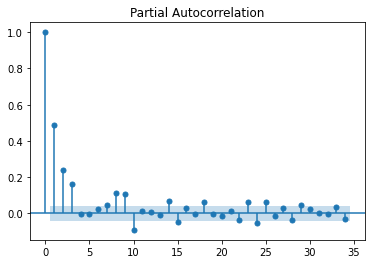

In [17]:
plot_pacf(logreturn**2)
plt.show()

The pacf plot indicates that from lag 1 to lag 3
is out of significance level so that the past 3day values are relatively related to the current
value.

In [18]:
for i in range(3):
    for j in range(3):
        gm_model = arch_model(logreturn*100, p=i+1,q=j+1, dist='skewt')
        gjr_model = arch_model(logreturn*100, p=i+1, q=j+1, o=i+1,dist='skewt')
        gm_fit = gm_model.fit(disp='off')
        gjr_fit = gjr_model.fit(disp='off')

        print('GARCH({},{}) AIC, BIC: {:.3f} and {:.3f}'.format(i+1,j+1,gm_fit.aic, gm_fit.bic))
        print('GJR-GARCH({},{}) AIC, BIC: {:.3f} and {:.3f}'.format(i+1,j+1,gjr_fit.aic, gjr_fit.bic))

GARCH(1,1) AIC, BIC: 6269.375 and 6304.211
GJR-GARCH(1,1) AIC, BIC: 6223.638 and 6264.279
GARCH(1,2) AIC, BIC: 6271.375 and 6312.017
GJR-GARCH(1,2) AIC, BIC: 6224.962 and 6271.409
GARCH(1,3) AIC, BIC: 6273.375 and 6319.822
GJR-GARCH(1,3) AIC, BIC: 6225.551 and 6277.804
GARCH(2,1) AIC, BIC: 6269.050 and 6309.691
GJR-GARCH(2,1) AIC, BIC: 6226.024 and 6278.277
GARCH(2,2) AIC, BIC: 6269.124 and 6315.571
GJR-GARCH(2,2) AIC, BIC: 6227.627 and 6285.686
GARCH(2,3) AIC, BIC: 6264.421 and 6316.674
GJR-GARCH(2,3) AIC, BIC: 6228.285 and 6292.150
GARCH(3,1) AIC, BIC: 6271.050 and 6317.497
GJR-GARCH(3,1) AIC, BIC: 6229.579 and 6293.444
GARCH(3,2) AIC, BIC: 6271.124 and 6323.377
GJR-GARCH(3,2) AIC, BIC: 6231.447 and 6301.118
GARCH(3,3) AIC, BIC: 6266.418 and 6324.477
GJR-GARCH(3,3) AIC, BIC: 6230.610 and 6306.087


## Results
| Models        | AIC        | BIC       |
| :------------ |:----------:| :---------:|
| GARCH(1,1)    | 4714.78    | **4748.17**    |
| GARCH(1,2)    | 4716.78    | 4755.73   |
| GARCH(1,3)    | 4718.78    | 4763.30   |
| GARCH(2,1)    | 4714.86    | 4753.82   |
| GARCH(2,2)    | 4714.74    | 4759.26   |
| **GARCH(2,3)**    | **4709.42**    | 4759.51   |
| GARCH(3,1)    | 4716.86    | 4761.38   |
| GARCH(3,2)    | 4716.74    | 4766.83   |
| GARCH(3,3)    | 4711.42    | 4767.07   |

| Models        | AIC        | BIC       |
| :------------ |:----------:| :---------:|
| **GJR-GARCH(1,1)**    | **4673.58**    | **4712.54**   |
| GJR-GARCH(1,2)    | 4675.58    | 4720.10   |
| GJR-GARCH(1,3)    | 4677.24    | 4727.32   |
| GJR-GARCH(2,1)    | 4677.58    | 4727.67   |
| GJR-GARCH(2,2)    | 4679.36    | 4735.00   |
| GJR-GARCH(2,3)    | 4679.86    | 4741.07   |
| GJR-GARCH(3,1)    | 4681.58    | 4742.80   |
| GJR-GARCH(3,2)    | 4683.36    | 4750.14   |
| GJR-GARCH(3,3)    | 4683.22    | 4755.57   |

## Model selection (FNN and LSTM)

The model selection process of neural networks will be conducted by forecasting 1 day ahead volatility.

In [19]:
Xtrain, ytrain, Xtest, ytest, scaler = data_prep(data, target, split_index, status=0,n_ahead=1, window=22)

In [21]:
lstm_regressor = KerasRegressor(build_fn=create_lstm, epochs=50, verbose=0, batch_size=32)

The following process is model selection of LSTM. The candidate parameters are the number of neurons at each layer,
epochs, and learning rate. There are total 64 candidates of LSTM structures

In [23]:
params = dict(neurons1=[10,20,32,64],
              neurons2=[10,20,32,64],
              epochs=[50,100],
              lr=[0.001,0.0005])
grid = GridSearchCV(estimator=lstm_regressor, param_grid=params, verbose=10)
grid_result = grid.fit(Xtrain,ytrain)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5; 1/64] START epochs=50, lr=0.001, neurons1=10, neurons2=10..............
[CV 1/5; 1/64] END epochs=50, lr=0.001, neurons1=10, neurons2=10; total time=  40.5s
[CV 2/5; 1/64] START epochs=50, lr=0.001, neurons1=10, neurons2=10..............
[CV 2/5; 1/64] END epochs=50, lr=0.001, neurons1=10, neurons2=10; total time=  39.9s
[CV 3/5; 1/64] START epochs=50, lr=0.001, neurons1=10, neurons2=10..............
[CV 3/5; 1/64] END epochs=50, lr=0.001, neurons1=10, neurons2=10; total time=  39.5s
[CV 4/5; 1/64] START epochs=50, lr=0.001, neurons1=10, neurons2=10..............
[CV 4/5; 1/64] END epochs=50, lr=0.001, neurons1=10, neurons2=10; total time=  39.9s
[CV 5/5; 1/64] START epochs=50, lr=0.001, neurons1=10, neurons2=10..............
[CV 5/5; 1/64] END epochs=50, lr=0.001, neurons1=10, neurons2=10; total time=  39.7s
[CV 1/5; 2/64] START epochs=50, lr=0.001, neurons1=10, neurons2=20..............
[CV 1/5; 2/64] END epochs=5

In [24]:
ann_regressor = KerasRegressor(build_fn=create_ann, epochs=50, verbose=0, batch_size=32)

The same process for FNN.

In [25]:
params = dict(neurons1=[64,32,16],
              neurons2=[64,32,16],
              neurons3=[64,32,16],
              lr=[0.001,0.0005],
              epochs=[50,100]
              )
grid2 = GridSearchCV(estimator=ann_regressor, param_grid=params, verbose=10)
grid_result2 = grid2.fit(Xtrain, ytrain)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5; 1/108] START epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64
[CV 1/5; 1/108] END epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64; total time=   2.6s
[CV 2/5; 1/108] START epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64
[CV 2/5; 1/108] END epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64; total time=   2.8s
[CV 3/5; 1/108] START epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64
[CV 3/5; 1/108] END epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64; total time=   2.8s
[CV 4/5; 1/108] START epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64
[CV 4/5; 1/108] END epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64; total time=   2.9s
[CV 5/5; 1/108] START epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64
[CV 5/5; 1/108] END epochs=50, lr=0.001, neurons1=64, neurons2=64, neurons3=64; total time=   2.8s
[CV 1/5; 2/108] START epochs=50, lr=0

In [26]:
print('LSTM configuration is: {}'.format(grid_result.best_params_))
print('FNN configuration is: {}'.format(grid_result2.best_params_))

LSTM configuration is: {'epochs': 50, 'lr': 0.0005, 'neurons1': 10, 'neurons2': 64}
FNN configuration is: {'epochs': 50, 'lr': 0.001, 'neurons1': 64, 'neurons2': 16, 'neurons3': 32}


## Forecast volatility

In [71]:
window = 22
n_ahead=1
batch_size=32
epochs=50

In [72]:
garch_estim = create_garch(data, target, window=window, n_ahead=n_ahead)
gjr_estim = create_gjr(data, target, window=window, n_ahead=n_ahead)
print(garch_estim)
print(gjr_estim)

c:\users\user\cxk858\cxk858\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\user\cxk858\cxk858\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
c:\users\user\cxk858\cxk858\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
c:\users\user\cxk858\cxk858\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
c:\users\user\cxk858\cxk858\lib\site-packages\scipy\optimize\optimize.py:282: Run

garch pred length:  2433
target length:  2433
-----GARCH estimation done-----
garch pred length:  2433
target length:  2433
-----GJR-GARCH estimation done-----
         GARCH
0     0.177048
1     0.168405
2     0.163968
3     0.196177
4     0.184657
...        ...
2428  0.148612
2429  0.171555
2430  0.158975
2431  0.170072
2432  0.155408

[2433 rows x 1 columns]
           GJR
0     0.151513
1     0.182979
2     0.179445
3     0.213764
4     0.167577
...        ...
2428  0.146696
2429  0.142303
2430  0.138844
2431  0.134431
2432  0.130434

[2433 rows x 1 columns]


In [73]:
gjr_estim.iloc[18] = (gjr_estim.iloc[17]+gjr_estim.iloc[19])/2
data_g = data.copy()
data_g['GARCH'] = garch_estim['GARCH']
data_r = data.copy()
data_r['GJR'] = gjr_estim['GJR']
data_gr = data.copy()
data_gr['GJR'] = gjr_estim['GJR']
data_gr['GARCH'] = garch_estim['GARCH']

Based on the result of model selection section, the optimum parameters are selected then the forecasting experiment will be
proceeded from now on.

In [94]:
def forecast_gjr(data, target, n_ahead=1):
    logreturns = np.array(data[['Daily_log_return']].dropna())
    gjr_pred = []
    n_ahead = n_ahead
    arr_target = np.array(target)
    mean_target = []
    for i in range(split_index, len(target)-n_ahead):
        window_target = arr_target[i:i+n_ahead]
        mean_target.append(window_target.mean())
    for i in range(split_index+22, len(logreturns)-n_ahead):
        train = logreturns[:i-1] * 100
        gm = arch_model(train, p=1, q=1, o=1, dist='skewt')
        gm_fit = gm.fit(disp='off')
        pred = gm_fit.forecast(horizon=n_ahead)
        gjr_pred.append(np.sqrt(pred.variance.values[-1, :].mean()) *0.01* np.sqrt(252))

    print(mean_target)
    print(gjr_pred)
    title = 'GJR-GARCH({},{}) prediction'.format(1,1)
    split_target = np.array(target.iloc[split_index-22:])
    plot(gjr_pred, mean_target, title, save=True)

    print('---------GJR-GARCH({},{}) estimation-----------'.format(1,1))
    evaluate(predict=gjr_pred, target=mean_target, title=title)

In [95]:
def forecast_garch(data, target, n_ahead=1):
    logreturns = np.array(data[['Daily_log_return']])
    window = 22
    n_ahead = n_ahead
    garch_pred = []
    arr_target = np.array(target)
    mean_target = []
    for i in range(split_index, len(target)-n_ahead):
        window_target = arr_target[i:i+n_ahead]
        mean_target.append(window_target.mean())
    for i in range(split_index+22, len(logreturns)-n_ahead):
        train = logreturns[:i-1]*100
        gm = arch_model(train, p=1, q=1, dist='skewt')
        gm_fit = gm.fit(disp='off')
        pred = gm_fit.forecast(horizon=n_ahead)
        vol = np.sqrt(pred.variance.values[-1,:].mean())*0.01*np.sqrt(252)
        garch_pred.append(vol)
    print(mean_target)
    print(garch_pred)
    title = 'GARCH({},{}) prediction'.format(1,1)
    split_target = np.array(target.iloc[split_index-22:])
    plot(garch_pred, mean_target, title, save=True)

    print('---------GARCH({},{}) estimation-----------'.format(1,1))
    evaluate(predict=garch_pred, target=mean_target, title=title)
    # mt.testScore(pred=garch_pred, target=mean_target)

In [76]:
def build_optimised_lstm(x, output):
    model = Sequential()
    model.add(LSTM(units=64, input_dim=x.shape[2], return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=32, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(output))

    adam = Adam(learning_rate=0.0005)
    model.compile(loss='mae', optimizer=adam)

    return model

In [77]:
def build_optimised_ann(x, output):
    model = Sequential()
    model.add(Flatten(input_shape=(x.shape[1], x.shape[2])))
    model.add(Dense(64, activation='tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(output))
    adam = Adam(learning_rate=0.001)
    model.compile(loss='mae', optimizer=adam)
    return model

In [87]:
def run_ann(window=22, n_ahead=1,status=0):
    if status==0:
        Xtrain, ytrain, Xtest, ytest, scaler = data_prep(data, target, split_index, status=status,n_ahead=n_ahead, window=window)

        model = build_optimised_ann(Xtrain, n_ahead)

        for i in range(epochs):
            model.fit(Xtrain, ytrain, batch_size=batch_size,verbose=0)
            # model.reset_states()
        forecast = model.predict(Xtest, batch_size=batch_size)
        forecast = forecast.mean(axis=1).reshape(len(forecast),1)
        ytest = ytest.mean(axis=1).reshape(len(ytest),1)
        rev_forecast = scaler.inverse_transform(forecast)
        rev_ytest = scaler.inverse_transform(ytest)
        title = '{} window FNN {}days ahead forecast'.format(window, n_ahead)

    elif status==1:
        Xtrain_garch, ytrain_garch, Xtest_garch, ytest_garch, scaler_garch = data_prep(data_g, target, split_index, status=status,n_ahead=n_ahead, window=window)
        model = build_optimised_ann(Xtrain_garch, output=n_ahead)
        for i in range(epochs):
            model.fit(Xtrain_garch, ytrain_garch, batch_size=batch_size,verbose=0)
            model.reset_states()
        forecast = model.predict(Xtest_garch, batch_size=batch_size)
        forecast = forecast.mean(axis=1).reshape(len(forecast),1)
        ytest = ytest_garch.mean(axis=1).reshape(len(ytest_garch),1)
        rev_forecast = scaler_garch.inverse_transform(forecast)
        rev_ytest = scaler_garch.inverse_transform(ytest)
        title = '{} window G-FNN {}days ahead forecast'.format(window, n_ahead)
    elif status==2:

        Xtrain_gjr, ytrain_gjr, Xtest_gjr, ytest_gjr, scaler_gjr = data_prep(data_r, target, split_index, status=status,n_ahead=n_ahead, window=window)
        model = build_optimised_ann(Xtrain_gjr, output=n_ahead)
        for i in range(epochs):
            model.fit(Xtrain_gjr, ytrain_gjr, batch_size=batch_size,verbose=0)
            model.reset_states()
        forecast = model.predict(Xtest_gjr, batch_size=batch_size)
        forecast = forecast.mean(axis=1).reshape(len(forecast),1)
        ytest = ytest_gjr.mean(axis=1).reshape(len(ytest_gjr),1)
        rev_forecast = scaler_gjr.inverse_transform(forecast)
        rev_ytest = scaler_gjr.inverse_transform(ytest)
        title = '{} window R-FNN {}days ahead forecast'.format(window, n_ahead)
    elif status==3:
        Xtrain_gr, ytrain_gr, Xtest_gr, ytest_gr, scaler_gr = data_prep(data_gr, target, split_index, status=status,n_ahead=n_ahead, window=window)
        model = build_optimised_ann(Xtrain_gr, output=n_ahead)
        for i in range(epochs):
            model.fit(Xtrain_gr, ytrain_gr, batch_size=batch_size,verbose=0)
            model.reset_states()
        forecast = model.predict(Xtest_gr, batch_size=batch_size)
        forecast = forecast.mean(axis=1).reshape(len(forecast),1)
        ytest = ytest_gr.mean(axis=1).reshape(len(ytest_gr),1)
        rev_forecast = scaler_gr.inverse_transform(forecast)
        rev_ytest = scaler_gr.inverse_transform(ytest)
        title = '{} window GR-FNN {}days ahead forecast'.format(window, n_ahead)

    plot(rev_forecast, rev_ytest, title, save=True)
    evaluate(rev_forecast, rev_ytest, 'ANN')

In [88]:
def run_lstm(window=22, n_ahead=1,status=0):

    if status==0:
        Xtrain, ytrain, Xtest, ytest, scaler = data_prep(data, target, split_index, status=status,n_ahead=n_ahead, window=window)
        model = build_optimised_lstm(Xtrain, output=n_ahead)
        for i in range(epochs):
            model.fit(Xtrain, ytrain, batch_size=batch_size, shuffle=False,verbose=0)
            # model.reset_states()
        forecast = model.predict(Xtest, batch_size=batch_size)
        forecast = forecast.mean(axis=1).reshape(len(forecast),1)
        ytest = ytest.mean(axis=1).reshape(len(ytest),1)
        rev_forecast = scaler.inverse_transform(forecast)
        rev_ytest = scaler.inverse_transform(ytest)
        title = '{} window LSTM {}days ahead forecast'.format(window, n_ahead)
    elif status==1:
        Xtrain_garch, ytrain_garch, Xtest_garch, ytest_garch, scaler_garch = data_prep(data_g, target, split_index, status=status,n_ahead=n_ahead, window=window)
        model = build_optimised_lstm(Xtrain_garch, output=n_ahead)
        for i in range(epochs):
            model.fit(Xtrain_garch, ytrain_garch, batch_size=batch_size, shuffle=False,verbose=0)
            model.reset_states()
        forecast = model.predict(Xtest_garch, batch_size=batch_size)
        forecast = forecast.mean(axis=1).reshape(len(forecast),1)
        ytest = ytest_garch.mean(axis=1).reshape(len(ytest_garch),1)
        rev_forecast = scaler_garch.inverse_transform(forecast)
        rev_ytest = scaler_garch.inverse_transform(ytest)
        title = '{} window G-LSTM {}days ahead forecast'.format(window, n_ahead)
    elif status==2:
        Xtrain_gjr, ytrain_gjr, Xtest_gjr, ytest_gjr, scaler_gjr = data_prep(data_r, target, split_index, status=status,n_ahead=n_ahead, window=window)
        model = build_optimised_lstm(Xtrain_gjr, output=n_ahead)
        for i in range(epochs):
            model.fit(Xtrain_gjr, ytrain_gjr, batch_size=batch_size, shuffle=False, verbose=0)
            model.reset_states()
        forecast = model.predict(Xtest_gjr, batch_size=batch_size)
        forecast = forecast.mean(axis=1).reshape(len(forecast),1)
        ytest = ytest_gjr.mean(axis=1).reshape(len(ytest_gjr),1)
        rev_forecast = scaler_gjr.inverse_transform(forecast)
        rev_ytest = scaler_gjr.inverse_transform(ytest)
        title = '{} window R-LSTM {}days ahead forecast'.format(window, n_ahead)
    elif status==3:
        Xtrain_gr, ytrain_gr, Xtest_gr, ytest_gr, scaler_gr = data_prep(data_gr, target, split_index, status=status,n_ahead=n_ahead, window=window)
        model = build_optimised_lstm(Xtrain_gr, output=n_ahead)
        for i in range(epochs):
            model.fit(Xtrain_gr, ytrain_gr, batch_size=batch_size, shuffle=False,verbose=0)
            model.reset_states()
        forecast = model.predict(Xtest_gr, batch_size=batch_size)
        forecast = forecast.mean(axis=1).reshape(len(forecast),1)
        ytest = ytest_gr.mean(axis=1).reshape(len(ytest_gr),1)
        rev_forecast = scaler_gr.inverse_transform(forecast)
        rev_ytest = scaler_gr.inverse_transform(ytest)
        title = '{} window GR-LSTM {}days ahead forecast'.format(window, n_ahead)

    plot(rev_forecast, rev_ytest, title, save=True)
    evaluate(rev_forecast, rev_ytest, 'LSTM')

The 1day ahead forecast is first conducted then 5 days ahead forecast will be conducted after modifying the variables

[0.14973701107826273, 0.15069328210274996, 0.14723099280626975, 0.15620034568702856, 0.14944688569849912, 0.14807459137700532, 0.1430674174242928, 0.1431059040155328, 0.14263809091506688, 0.14114018861705582, 0.1382986593841729, 0.14531543933587768, 0.1442801864499259, 0.13289634715042717, 0.1344726608465256, 0.13500202783794701, 0.11856159656810891, 0.11140372377679547, 0.12377788936770413, 0.11906490618184419, 0.11483007797432083, 0.10066617042215589, 0.10338679157566416, 0.11764148342920157, 0.1149669922252888, 0.10724641227033775, 0.11098322520127561, 0.1112488006128213, 0.10958094431260905, 0.10943824992150977, 0.10912247108163634, 0.10889957299725907, 0.12602699681810148, 0.11605256821716152, 0.11753640781391429, 0.11725599035934671, 0.11187053292220205, 0.11939193971675438, 0.11950794504983878, 0.12441255353304728, 0.11869213215219176, 0.11921991458439997, 0.12284950647148601, 0.1216054244413231, 0.11461039394794309, 0.10574812413185575, 0.10372444693272338, 0.10362610574260009,

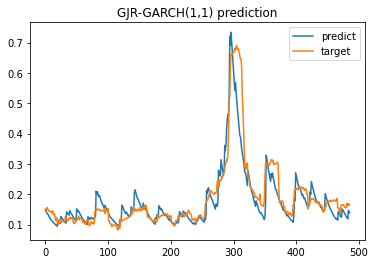

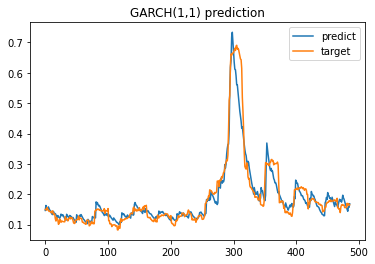

In [80]:
forecast_gjr(data, target=target, n_ahead=1)
forecast_garch(data, target, n_ahead=1)

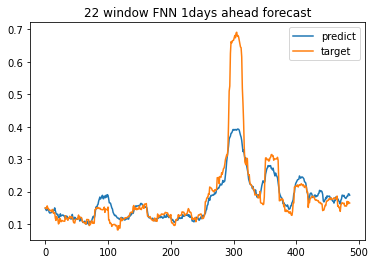

--------ANN----------
test Score: 0.0037287312479510515 MSE
test Score: 0.06106333800203729 RMSE
test Score: 0.11658657228400743 MAPE
test Score: 0.027621473994325928 MAE
--------LSTM----------
test Score: 0.0028541003662144616 MSE
test Score: 0.05342378090527159 RMSE
test Score: 0.11576997055245236 MAPE
test Score: 0.02667958496225119 MAE
--------ANN----------
test Score: 0.0029204071293509365 MSE
test Score: 0.05404079134645362 RMSE
test Score: 0.09791125382446725 MAPE
test Score: 0.02384735016287 MAE
--------LSTM----------
test Score: 0.0013448527441817506 MSE
test Score: 0.036672233967700286 RMSE
test Score: 0.103945020576569 MAPE
test Score: 0.02154905538245687 MAE
--------ANN----------
test Score: 0.0024611470594329424 MSE
test Score: 0.04960994919804839 RMSE
test Score: 0.09902067341643088 MAPE
test Score: 0.02312843610235483 MAE
--------LSTM----------
test Score: 0.0014222009811026494 MSE
test Score: 0.03771208004211183 RMSE
test Score: 0.09296183755667253 MAPE
test Score: 0.02

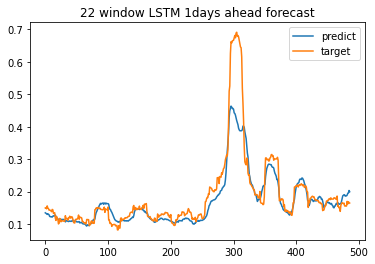

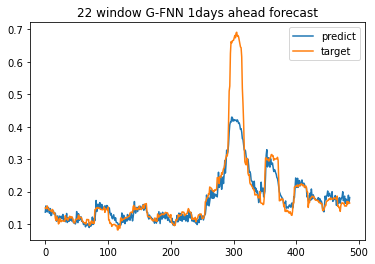

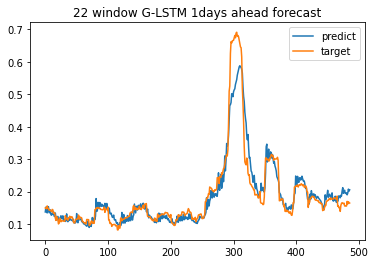

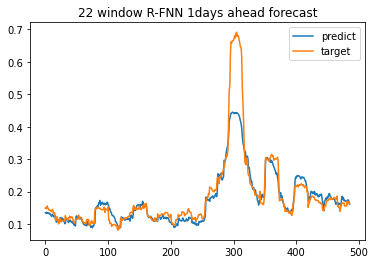

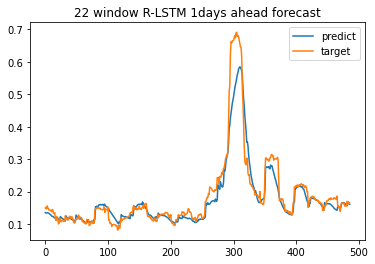

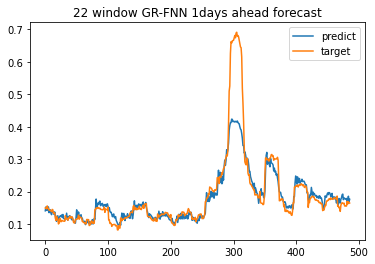

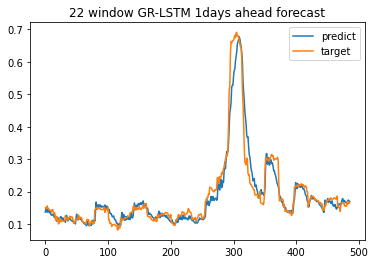

In [81]:
# data = data.drop(['past_vol'], axis=1)
for i in range(4):
    run_ann(window=window,n_ahead=n_ahead, status=i)
    run_lstm(window=window,n_ahead=n_ahead, status=i)

From here, 5 days ahead forecast

[0.150661703474562, 0.15032921953431055, 0.14880404659861912, 0.1479790288404717, 0.14526657788607938, 0.14360523846979073, 0.14165005207122422, 0.14209965645354122, 0.14233451294041982, 0.1403861641874919, 0.13905265863338587, 0.13839333232414067, 0.13304256377058693, 0.12646727123596083, 0.12464357967941622, 0.12156202874647995, 0.11752763877375472, 0.1139485535445641, 0.11234516710433784, 0.11111788591663734, 0.11029830312532625, 0.10878156998452963, 0.11084498094035358, 0.11241738274778501, 0.1108052749244665, 0.1096995264637107, 0.1100747382259704, 0.1096580077851671, 0.11261364702622315, 0.11390797180713363, 0.11552760338561455, 0.11715430724115661, 0.1177484992261452, 0.1164214878058758, 0.11711256317241123, 0.11848779231623782, 0.11877502067480686, 0.12024489700724643, 0.12093641035819276, 0.12135590623648965, 0.11939547431946877, 0.11680667271540157, 0.11370757918506627, 0.10986289903928907, 0.10840408023011902, 0.10846045714157908, 0.11022255099680896, 0.11270579164477841, 0.

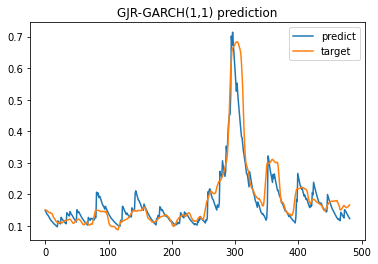

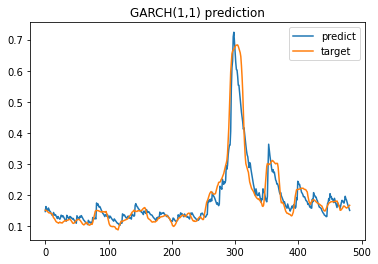

In [96]:
forecast_gjr(data, target=target, n_ahead=5)
forecast_garch(data, target, n_ahead=5)

In [83]:
n_ahead = 5

In [84]:
garch_estim = create_garch(data, target, window=window, n_ahead=n_ahead)
gjr_estim = create_gjr(data, target, window=window, n_ahead=n_ahead)
print(garch_estim)
print(gjr_estim)

c:\users\user\cxk858\cxk858\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\users\user\cxk858\cxk858\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
c:\users\user\cxk858\cxk858\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
c:\users\user\cxk858\cxk858\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
c:\users\user\cxk858\cxk858\lib\site-packages\scipy\optimize\optimize.py:282: Run

garch pred length:  2429
target length:  2429
-----GARCH estimation done-----
garch pred length:  2429
target length:  2429
-----GJR-GARCH estimation done-----
         GARCH
0     0.182730
1     0.172551
2     0.167243
3     0.200828
4     0.197320
...        ...
2424  0.162081
2425  0.157398
2426  0.151066
2427  0.144369
2428  0.158440

[2429 rows x 1 columns]
           GJR
0     0.154990
1     0.189766
2     0.184028
3     0.221437
4     0.170824
...        ...
2424  0.129779
2425  0.126186
2426  0.122839
2427  0.119757
2428  0.146679

[2429 rows x 1 columns]


In [85]:
gjr_estim.iloc[18] = (gjr_estim.iloc[17]+gjr_estim.iloc[19])/2
data_g = data.copy()
data_g['GARCH'] = garch_estim['GARCH']
data_r = data.copy()
data_r['GJR'] = gjr_estim['GJR']
data_gr = data.copy()
data_gr['GJR'] = gjr_estim['GJR']
data_gr['GARCH'] = garch_estim['GARCH']

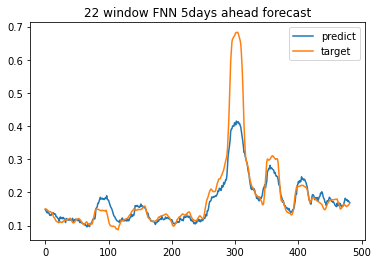

--------ANN----------
test Score: 0.00325011516603256 MSE
test Score: 0.05700978131893298 RMSE
test Score: 0.10539714069643086 MAPE
test Score: 0.025762381630328235 MAE
--------LSTM----------
test Score: 0.0019709006279195686 MSE
test Score: 0.044394826589587766 RMSE
test Score: 0.11313353416992433 MAPE
test Score: 0.024920060014222218 MAE
--------ANN----------
test Score: 0.00333704721784926 MSE
test Score: 0.05776718114854887 RMSE
test Score: 0.09301523334202251 MAPE
test Score: 0.02502619361155405 MAE
--------LSTM----------
test Score: 0.001980729128313152 MSE
test Score: 0.04450538313859518 RMSE
test Score: 0.09670026877333823 MAPE
test Score: 0.022883646470082494 MAE
--------ANN----------
test Score: 0.0027865876266830025 MSE
test Score: 0.05278813907198285 RMSE
test Score: 0.09367944141840927 MAPE
test Score: 0.023647225817201547 MAE
--------LSTM----------
test Score: 0.0030047021930522944 MSE
test Score: 0.05481516389697557 RMSE
test Score: 0.12182054813101464 MAPE
test Score: 0

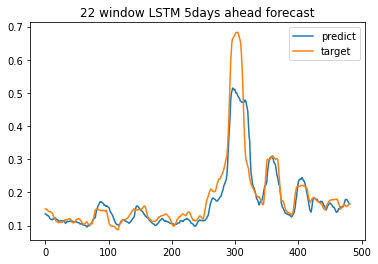

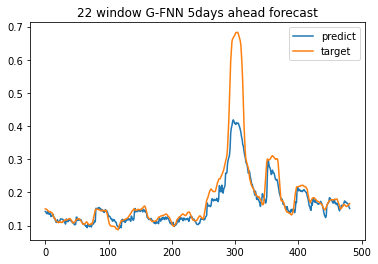

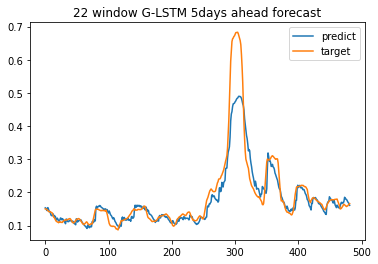

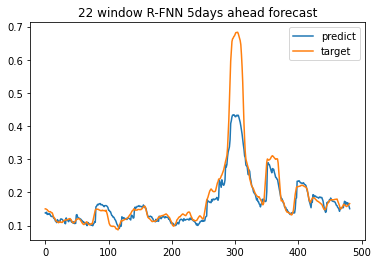

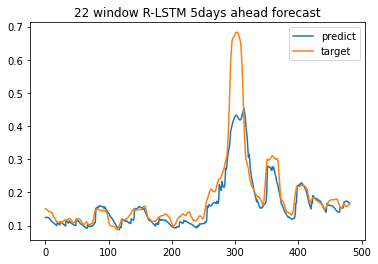

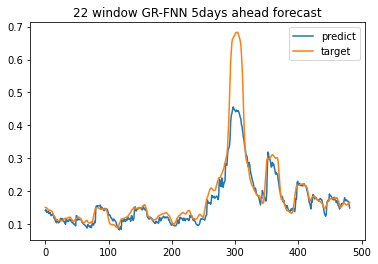

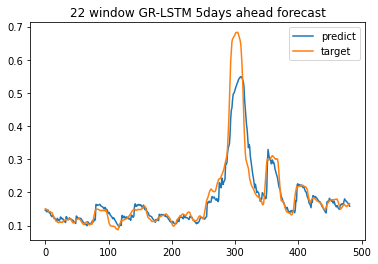

In [93]:
for i in range(4):
    run_ann(window=window,n_ahead=n_ahead, status=i)
    run_lstm(window=window,n_ahead=n_ahead, status=i)